In [1]:
'''from google.colab import drive
drive.mount('/content/drive')'''

"from google.colab import drive\ndrive.mount('/content/drive')"

In [2]:
#!tar -xvf  'data-split.tar.xz'

# Plant Disease Detection Using Pretrained VGG16

In [3]:
import os
import shutil
import itertools
import random
import json
import cv2
import imutils
from imutils import paths
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle

import keras
from keras import backend as K
from keras.applications import imagenet_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import img_to_array
from keras.metrics import categorical_crossentropy
from keras.optimizers import Adam
from keras.models import Sequential, Model, load_model

from keras.layers import Activation, BatchNormalization
from keras.layers.core import Dense, Flatten
from keras.layers.convolutional import *
from sklearn.metrics import confusion_matrix
from scipy import misc, ndimage

In [4]:
gen = ImageDataGenerator(rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.15,
                        zoom_range=0.1,
                        channel_shift_range=10,
                        horizontal_flip=True)

### Data Preparation

In [5]:
base_path= 'data-split/'
train_path = os.path.join(base_path, 'train')
valid_path = os.path.join(base_path, 'valid')
test_path = os.path.join(base_path, 'test')

In [6]:
with open('label.json', 'r') as f:
    cat = json.load(f)
categories = list(cat.keys())
categories

['Apple-Scab', 'Black-Rot', 'Healthy', 'Cedar-Apple-Rust']

In [7]:
# ImageDataGenerator for transformations
train_gen = ImageDataGenerator(rotation_range=10,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        shear_range=0.15,
                        zoom_range=0.1,
                        channel_shift_range=10,
                        horizontal_flip=True)

In [8]:
train_batches = train_gen.flow_from_directory(train_path,
                                              target_size=(64, 64),
                                              classes=categories,
                                              batch_size=20)
valid_batches = ImageDataGenerator().flow_from_directory(valid_path,
                                                         target_size=(64, 64),
                                                         classes=categories,
                                                         batch_size=10)
test_batches = ImageDataGenerator().flow_from_directory(test_path,
                                                         target_size=(64, 64),
                                                         classes=categories,
                                                         batch_size=10)

Found 2536 images belonging to 4 classes.
Found 319 images belonging to 4 classes.
Found 321 images belonging to 4 classes.


### Build CNN Model

In [9]:
vgg16_model = keras.applications.vgg16.VGG16(include_top=False, input_shape=(64,64,3))

In [10]:
vgg16_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [11]:
# add dropout layers to the model
model = Sequential()
for layer in vgg16_model.layers:
    if "pool" in layer.name:
        model.add(BatchNormalization())
    model.add(layer)

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       5

In [13]:
# freeze the first three layers of the model
NUM_TRAINABLE_LAYERS = len(vgg16_model.layers) - 3
for layer in model.layers[:-NUM_TRAINABLE_LAYERS]:
    layer.trainable = False

In [14]:
# add layers to the end of the model
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(categories), activation='softmax'))

In [15]:
# final model architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 64, 64, 64)        256       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 128)       5

### Training the model

In [16]:
BS = 32
epochs = 150

In [17]:
model.compile(Adam(lr=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
history = model.fit(train_batches, steps_per_epoch=train_batches.samples//BS,
                   validation_data=valid_batches, validation_steps=valid_batches.samples//BS,
                   epochs=epochs,
                   verbose=1)

Epoch 1/150
79/79 [==============================] - 11s 84ms/step - loss: 0.7507 - accuracy: 0.6813 - val_loss: 0.8994 - val_accuracy: 0.6778
Epoch 2/150
79/79 [==============================] - 5s 63ms/step - loss: 0.2008 - accuracy: 0.9351 - val_loss: 0.2966 - val_accuracy: 0.8778
Epoch 3/150
79/79 [==============================] - 5s 64ms/step - loss: 0.2117 - accuracy: 0.9287 - val_loss: 0.1569 - val_accuracy: 0.9556
Epoch 4/150
79/79 [==============================] - 5s 63ms/step - loss: 0.1487 - accuracy: 0.9563 - val_loss: 0.3320 - val_accuracy: 0.8778
Epoch 5/150
79/79 [==============================] - 5s 63ms/step - loss: 0.1496 - accuracy: 0.9468 - val_loss: 0.0954 - val_accuracy: 0.9667
Epoch 6/150
79/79 [==============================] - 5s 63ms/step - loss: 0.1092 - accuracy: 0.9611 - val_loss: 0.8169 - val_accuracy: 0.8778
Epoch 7/150
79/79 [==============================] - 5s 63ms/step - loss: 0.1230 - accuracy: 0.9567 - val_loss: 0.8536 - val_accuracy: 0.7667
Epoch

In [19]:
# Save the model 
filepath="model-VGG16.hdf5"
model.save(filepath)

### Evaluating Model

In [20]:
results = model.evaluate(test_batches, steps=test_batches.samples//BS)

10/10 [==============================] - 0s 18ms/step - loss: 0.0355 - accuracy: 0.9900


In [21]:
print("Accuracy = {:.2f}%".format(results[1]*100))

Accuracy = 99.00%


In [22]:
#plotting training values
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)

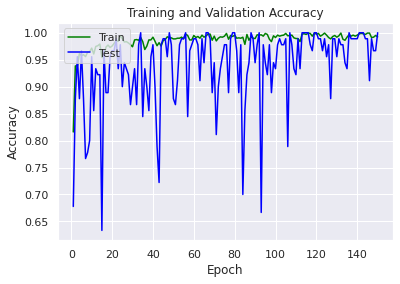

In [23]:
#accuracy plot
plt.plot(epochs, acc, color='green', label='Training Accuracy')
plt.plot(epochs, val_acc, color='blue', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

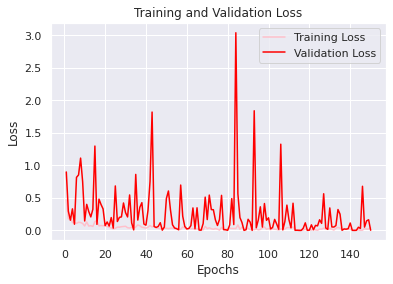

In [24]:
#loss plot
plt.plot(epochs, loss, color='pink', label='Training Loss')
plt.plot(epochs, val_loss, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

### Predictions

In [33]:
from google.colab.patches import cv2_imshow
import cv2

def predict(image, model):
  output = image.copy()

  # Preprocess the image for classification
  image = cv2.resize(image, (64, 64))
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)

  # Make the predictions
  proba = model.predict(image)[0]
  idx = np.argmax(proba)
  label = categories[idx]

  # Display the predictions
  label = "{}: {:.2f}% ".format(label, proba[idx] * 100)
  output = imutils.resize(output, width=400)
  cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 255, 0), 2)

  # show the output image
  cv2_imshow(output)

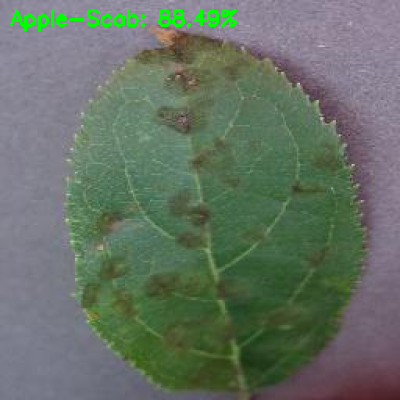

In [34]:
image = cv2.imread("/content/data-split/test/Apple-Scab/Apple-Scab563.jpg")
predict(image, model)

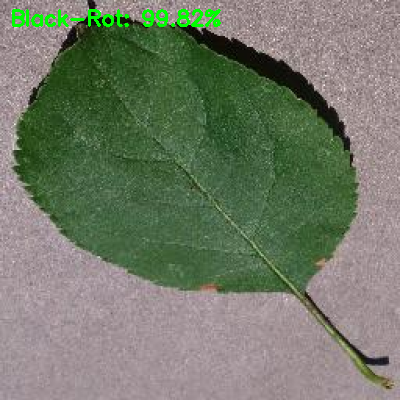

In [37]:
image = cv2.imread("/content/data-split/test/Black-Rot/Black-Rot551.jpg")
predict(image, model)

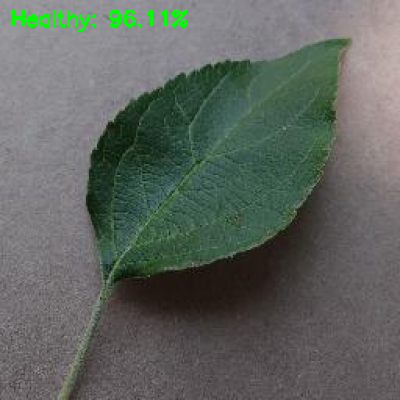

In [36]:
image = cv2.imread("/content/data-split/test/Healthy/Healthy1326.jpg")
predict(image, model)

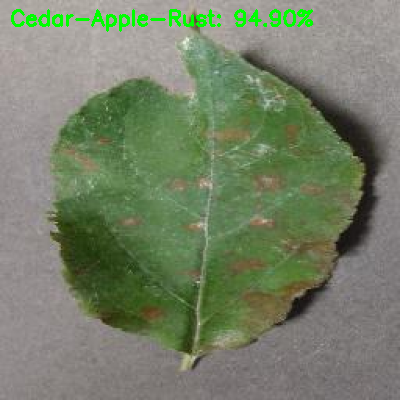

In [39]:
image = cv2.imread("/content/data-split/test/Cedar-Apple-Rust/Cedar-Apple-Rust243.jpg")
predict(image, model)